<a href="https://colab.research.google.com/github/LibertyChaser/price_prediction/blob/main/BTC_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

for file_name in uploaded.keys():
    print('Uploaded file name:', file_name)

Saving alltime_data.csv to alltime_data.csv
Uploaded file name: alltime_data.csv


In [2]:
!pip install keras-tcn optuna optuna.integration shap
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, InputLayer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import pandas as pd
from tcn import TCN, tcn_full_summary
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.samplers import TPESampler

np.random.seed(42)
tf.random.set_seed(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 14.1 MB/s eta 0:00:00


In [3]:
# Load the dataset
data = pd.read_csv('alltime_data.csv')
data = data.drop(columns=['Unnamed: 0'])

# Extract BTC-USDT data
btc_data = data[data['trading_pair'] == 'BTC-USDT']
btc_data = btc_data.drop(columns=['trading_pair'])

# Moving Average (MA)
def moving_average(data, window):
    return data.shift(1).rolling(window=window, min_periods=1).mean()

# Exponential Moving Average (EMA)
def exponential_moving_average(data, span):
    return data.shift(1).ewm(span=span, adjust=False, min_periods=1).mean()

# MACD
def macd(data, short_window, long_window):
    short_ema = exponential_moving_average(data.shift(1), short_window)
    long_ema = exponential_moving_average(data.shift(1), long_window)
    dif = short_ema - long_ema
    dea = dif.rolling(window=9, min_periods=1).mean()
    macd = 2 * (dif - dea)
    return macd, dif, dea

# Bias
def bias(data, window):
    ma = moving_average(data.shift(1), window)
    return (data - ma) / ma * 100

# On-Balance Volume (OBV)
def obv(data):
    obv = [0]
    for i in range(1, len(data)):
        if data['close'].shift(1).iloc[i] > data['close'].shift(1).iloc[i-1]:
            obv.append(obv[-1] + data['volume'].shift(1).iloc[i])
        elif data['close'].shift(1).iloc[i] < data['close'].shift(1).iloc[i-1]:
            obv.append(obv[-1] - data['volume'].shift(1).iloc[i])
        else:
            obv.append(obv[-1])
    return pd.Series(obv, index=data.index)

# Stock Strength (ST)
def stock_strength(data, window):
    p_n = data.shift(1).rolling(window=window, min_periods=1).apply(lambda x: x[-1], raw=True)
    p_1 = data.shift(1).rolling(window=window, min_periods=1).apply(lambda x: x[0], raw=True)
    numerator = p_n - p_1
    denominator = data.shift(1).rolling(window=window, min_periods=1).apply(lambda x: np.sum(np.abs(np.diff(x))), raw=True)
    return numerator / denominator

# Relative Change in Volume (Vol)
def volume_change(data):
    return data['volume'].shift(1).pct_change()

# Rate of Change (ROC)
def rate_of_change(data, window):
    return data.shift(1).pct_change(window)

# Momentum (MOM)
def momentum(data, window):
    return data.shift(1).diff(window)


# Calculate the features
btc_data['MA_7'] = moving_average(btc_data['close'], 7)
btc_data['MA_14'] = moving_average(btc_data['close'], 14)
btc_data['MA_30'] = moving_average(btc_data['close'], 30)

btc_data['EMA_7'] = exponential_moving_average(btc_data['close'], 7)
btc_data['EMA_14'] = exponential_moving_average(btc_data['close'], 14)
btc_data['EMA_30'] = exponential_moving_average(btc_data['close'], 30)
btc_data['EMA_90'] = exponential_moving_average(btc_data['close'], 90)

btc_data['MACD'], btc_data['DIF'], btc_data['DEA'] = macd(btc_data['close'], 14, 28)

btc_data['BIAS_7'] = bias(btc_data['close'], 7)
btc_data['BIAS_14'] = bias(btc_data['close'], 14)
btc_data['BIAS_30'] = bias(btc_data['close'], 30)

btc_data['OBV'] = obv(btc_data)

btc_data['ST_7'] = stock_strength(btc_data['close'], 7)
btc_data['ST_14'] = stock_strength(btc_data['close'], 14)
btc_data['ST_30'] = stock_strength(btc_data['close'], 30)

btc_data['Vol'] = volume_change(btc_data)

btc_data['ROC_7'] = rate_of_change(btc_data['close'], 7)
btc_data['ROC_14'] = rate_of_change(btc_data['close'], 14)
btc_data['ROC_30'] = rate_of_change(btc_data['close'], 30)

btc_data['MOM_1'] = momentum(btc_data['close'], 1)
btc_data['MOM_2'] = momentum(btc_data['close'], 2)
btc_data['MOM_3'] = momentum(btc_data['close'], 3)

# Define and calculate the binary result
btc_data['position'] = np.where(btc_data['close'] > btc_data['open'], 1, 0)

# Define and calculate the return
btc_data['return'] = (btc_data['close'].shift(1) / btc_data['open'].shift(1)) - 1

btc_data['close-1'] = btc_data['close'].shift(1)
btc_data['open-1'] = btc_data['open'].shift(1)
btc_data['high-1'] = btc_data['high'].shift(1)
btc_data['low-1'] = btc_data['low'].shift(1)
btc_data['volume-1'] = btc_data['volume'].shift(1)

# Drop any remaining rows with NaN values in the features
btc_data = btc_data.dropna()

# Display the processed data
btc_data.head()

,timestamp,open,high,low,close,volume,MA_7,MA_14,MA_30,EMA_7,...,MOM_1,MOM_2,MOM_3,position,return,close-1,open-1,high-1,low-1,volume-1
4468,2020-02-01,9364.50,9477.76,9306.00,9392.74,109040.285,9067.088571,8859.216429,8421.587333,9159.355118,...,-161.16,53.51,-34.47,1,-0.016918,9364.51,9525.67,9550.72,9220.00,146644.026
4469,2020-02-02,9392.99,9489.92,9160.01,9338.20,148402.977,9216.817143,8892.626429,8502.610667,9217.701338,...,28.23,-132.93,81.74,0,0.003016,9392.74,9364.50,9477.76,9306.00,109040.285
4470,2020-02-03,9340.49,9647.61,9250.00,9300.64,159049.385,9320.672857,8937.794286,8569.160000,9247.826004,...,-54.54,-26.31,-187.47,0,-0.005833,9338.20,9392.99,9489.92,9160.01,148402.977
4471,2020-02-04,9300.63,9368.00,9105.00,9198.35,147843.902,9375.962857,8984.268571,8634.157667,9261.029503,...,-37.56,-92.10,-63.87,0,-0.004266,9300.64,9340.49,9647.61,9250.00,159049.385
4472,2020-02-05,9198.32,9799.08,9179.88,9630.00,212311.697,9347.301429,9016.834286,8695.624000,9245.359627,...,-102.29,-139.85,-194.39,1,-0.010997,9198.35,9300.63,9368.00,9105.00,147843.902


In [4]:
features = ['open-1', 'close-1', 'high-1', 'low-1', 'volume-1', 'return', 'MA_7', 'MA_14', 'MA_30', 'EMA_7', 'EMA_14', 'EMA_30', 'EMA_90', 'MACD', 'BIAS_7', 'BIAS_14', 'BIAS_30', 'OBV', 'ST_7', 'ST_14', 'ST_30', 'Vol', 'ROC_7', 'ROC_14', 'ROC_30', 'MOM_1', 'MOM_2', 'MOM_3']
target = 'position'

from sklearn.preprocessing import MinMaxScaler

btc_data['timestamp'] = pd.to_datetime(btc_data['timestamp'])

start_date = '2020-01-31'
end_date = '2024-05-09'
btc_data = btc_data[(btc_data['timestamp'] >= start_date) & (btc_data['timestamp'] <= end_date)]

train_end_date = '2023-01-01'
validation_end_date = '2024-01-01'

train_data = btc_data[btc_data['timestamp'] < train_end_date]
validation_data = btc_data[(btc_data['timestamp'] >= train_end_date) & (btc_data['timestamp'] < validation_end_date)]
test_data = btc_data[btc_data['timestamp'] >= validation_end_date]

train_data = train_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

X_train = train_data[features].values
y_train = train_data[target].values
X_validation = validation_data[features].values
y_validation = validation_data[target].values
X_test = test_data[features].values
y_test = test_data[target].values

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [5]:
def create_model(trial):
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(GRU(
        units=trial.suggest_int('gru_units', 16, 128),
        return_sequences=True
    ))
    model.add(TCN(
        nb_filters=trial.suggest_int('nb_filters', 16, 64),
        kernel_size=trial.suggest_int('kernel_size', 2, 5),
        dilations=[1, 2, 4, 8],
        dropout_rate=trial.suggest_float('dropout_rate', 0.2, 0.5),
        return_sequences=False
    ))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)),
        metrics=['accuracy']
    )
    return model

# Optuna
def objective(trial):
    model = create_model(trial)
    callback = TFKerasPruningCallback(trial, 'val_accuracy')

    history = model.fit(
        X_train, y_train,
        validation_data=(X_validation, y_validation),
        epochs=50,
        batch_size=trial.suggest_int('batch_size', 16, 128),
        callbacks=[callback],
        verbose=0
    )

    val_accuracy = np.max(history.history['val_accuracy'])
    return val_accuracy

study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100)
print('Best hyperparameters: ', study.best_params)

[I 2024-07-01 23:49:55,522] A new study created in memory with name: no-name-7749ce80-2f59-4b04-919f-f450d374ba7b
[I 2024-07-01 23:50:23,358] Trial 0 finished with value: 0.7890411019325256 and parameters: {'gru_units': 58, 'nb_filters': 62, 'kernel_size': 4, 'dropout_rate': 0.379597545259111, 'learning_rate': 0.0002051338263087451, 'batch_size': 33}. Best is trial 0 with value: 0.7890411019325256.
[I 2024-07-01 23:50:36,066] Trial 1 finished with value: 0.6000000238418579 and parameters: {'gru_units': 22, 'nb_filters': 58, 'kernel_size': 4, 'dropout_rate': 0.4124217733388137, 'learning_rate': 0.00010994335574766199, 'batch_size': 125}. Best is trial 0 with value: 0.7890411019325256.
[I 2024-07-01 23:50:50,955] Trial 2 finished with value: 0.7890411019325256 and parameters: {'gru_units': 110, 'nb_filters': 26, 'kernel_size': 2, 'dropout_rate': 0.2550213529560302, 'learning_rate': 0.0004059611610484307, 'batch_size': 75}. Best is trial 0 with value: 0.7890411019325256.
[I 2024-07-01 23:

Best hyperparameters:  {'gru_units': 67, 'nb_filters': 54, 'kernel_size': 2, 'dropout_rate': 0.3542703315240835, 'learning_rate': 0.0015304852121831463, 'batch_size': 21}


In [6]:
best_params = study.best_params

X_train_combined = np.concatenate((X_train, X_validation))
y_train_combined = np.concatenate((y_train, y_validation))

model = Sequential()
model.add(InputLayer(input_shape=(X_train_combined.shape[1], X_train_combined.shape[2])))
model.add(GRU(
    units=best_params['gru_units'],
    return_sequences=True
))
model.add(TCN(
    nb_filters=best_params['nb_filters'],
    kernel_size=best_params['kernel_size'],
    dilations=[1, 2, 4, 8],
    dropout_rate=best_params['dropout_rate'],
    return_sequences=False
))
model.add(Dense(1, activation='sigmoid'))
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    metrics=['accuracy']
)
history = model.fit(
    X_train_combined, y_train_combined,
    epochs=50,
    batch_size=best_params['batch_size'],
    verbose=1
)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

Epoch 1/50
69/69 [==============================] - 6s 14ms/step - loss: 0.6968 - accuracy: 0.5203
Epoch 2/50
69/69 [==============================] - 1s 9ms/step - loss: 0.6947 - accuracy: 0.5217
Epoch 3/50
69/69 [==============================] - 1s 8ms/step - loss: 0.6930 - accuracy: 0.5161
Epoch 4/50
69/69 [==============================] - 1s 8ms/step - loss: 0.6868 - accuracy: 0.5608
Epoch 5/50
69/69 [==============================] - 1s 9ms/step - loss: 0.6872 - accuracy: 0.5259
Epoch 6/50
69/69 [==============================] - 1s 9ms/step - loss: 0.6702 - accuracy: 0.5874
Epoch 7/50
69/69 [==============================] - 1s 9ms/step - loss: 0.6561 - accuracy: 0.6098
Epoch 8/50
69/69 [==============================] - 1s 8ms/step - loss: 0.6183 - accuracy: 0.6545
Epoch 9/50
69/69 [==============================] - 1s 8ms/step - loss: 0.5528 - accuracy: 0.7063
Epoch 10/50
69/69 [==============================] - 1s 8ms/step - loss: 0.4915 - accuracy: 0.7636
Epoch 11/50
69/69 

5/5 [==============================] - 1s 3ms/step
Test Accuracy: 0.7692
Confusion Matrix:
[[56  0]
 [30 44]]
Gini Coefficient: 0.8547
5/5 [==============================] - 0s 3ms/step
Average Return: 0.0187
Standard Deviation of Return: 0.0246
Average Return on Positive Days: 0.0268
Average Return on Negative Days: -0.0082
Maximum Drawdown: 0.1950


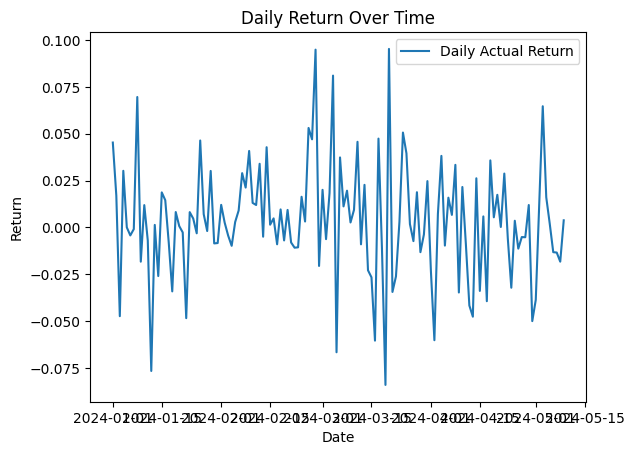

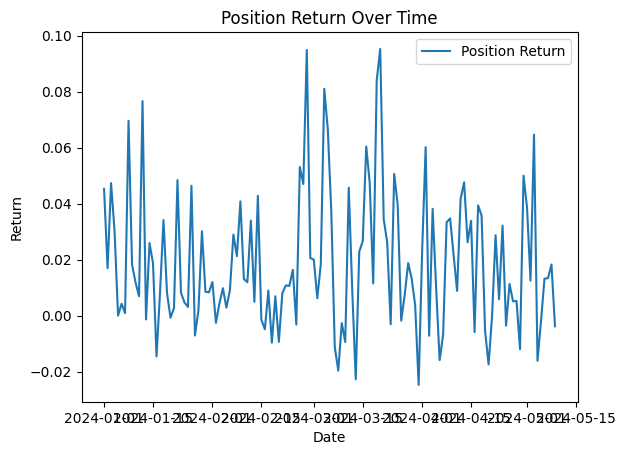

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Test Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Gini Coefficient
def gini_coefficient(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return 2 * roc_auc_score(y_true, y_prob) - 1

gini = gini_coefficient(y_test, y_pred_prob)
print(f'Gini Coefficient: {gini:.4f}')

# Predictions and actual returns
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
test_data['daily_return'] = (test_data['close'] / test_data['open']) - 1

# According to predicted position: long*1, short*(-1)
test_data['position_return'] = np.where(y_pred == 1, test_data['daily_return'], -test_data['daily_return'])

# Cross-checking predictions and returns
predictions_and_returns = test_data[['daily_return']].copy()
predictions_and_returns['predicted'] = y_pred
predictions_and_returns['position_return'] = np.where(y_pred == 1, test_data['daily_return'], -test_data['daily_return'])


# Calculate metrics
average_return = test_data['position_return'].mean()
std_return = test_data['position_return'].std()
average_return_positive = test_data[test_data['position_return'] > 0]['position_return'].mean()
average_return_negative = test_data[test_data['position_return'] < 0]['position_return'].mean()

# Calculate Maximum Drawdown
cumulative_return = (1 + test_data['position_return']).cumprod()
maximum_drawdown = (cumulative_return.cummax() - cumulative_return).max()

# Print results
print(f'Average Return: {average_return:.4f}')
print(f'Standard Deviation of Return: {std_return:.4f}')
print(f'Average Return on Positive Days: {average_return_positive:.4f}')
print(f'Average Return on Negative Days: {average_return_negative:.4f}')
print(f'Maximum Drawdown: {maximum_drawdown:.4f}')

# Plot the Actual Return and Predicted Return
plt.plot(test_data['timestamp'], test_data['daily_return'], label='Daily Actual Return')
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Daily Return Over Time')
plt.legend()
plt.show()

plt.plot(test_data['timestamp'], test_data['position_return'], label='Position Return')
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Position Return Over Time')
plt.legend()
plt.show()

In [8]:
start_date = pd.to_datetime('2024/01/01')
end_date = pd.to_datetime('2024/05/09')

filtered_data = test_data[(test_data['timestamp'] >= start_date) & (test_data['timestamp'] <= end_date)]

filtered_data['open'] = test_data['open']
filtered_data['close'] = test_data['close']
filtered_data['position'] = test_data['position']
filtered_data['prediction'] = y_pred
filtered_data['trading_pair'] = 'BTC/USDT'

output_data = filtered_data[['timestamp', 'open', 'close', 'position', 'prediction', 'trading_pair']]

output_data.to_csv('btc_usdt_3_predictions_filtered.csv', index=False)

print("CSV file has been saved successfully.")

CSV file has been saved successfully.
